In [28]:
#!pip install biopython

In [29]:
from google.colab import files

In [ ]:
files = files.upload()

In [5]:
import requests
import time

In [1]:
# Open your FASTA file
with open("cytochrome_c.fasta", "r") as file:
    fasta_data = file.read()

In [2]:

# Submit job to Clustal Omega (EBI API)

params = {
    'sequence': fasta_data,
    'email': 'simmymacbookair@gmail.com',
    'stype':'protein',
    'outfmt':'clustal_num'
}

In [3]:
url = 'https://www.ebi.ac.uk/Tools/services/rest/clustalo/run'

In [6]:
response = requests.post(url, data=params)

In [7]:
job_id = response.text
print('Job ID:',job_id)

Job ID: clustalo-R20250721-162952-0478-47398886-p1m


In [8]:
# Check status
status_url = f'https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}'
result_url = f'https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num'

In [9]:
# Wait for the job to finish

while True:
    status = requests.get(status_url).text
    print("Job Status:", status)
    if status == 'FINISHED':
        break
    time.sleep(5)

Job Status: FINISHED


In [10]:
# Get results
result = requests.get(result_url)
alignment_result = result.text

In [11]:
# Save alignment to file
with open("alignment_named.aln", "w") as out_file:
    out_file.write(alignment_result)

In [12]:
print("Alignment completed and saved as 'alignment_named.aln'")

Alignment completed and saved as 'alignment_named.aln'


In [13]:
from Bio import AlignIO

alignment = AlignIO.read("alignment_named.aln", "clustal")
print(alignment)

Alignment with 5 rows and 367 columns
--------------------------------------------...--- [Drosophila_melanogaster],
--------------------------------------------...--- [Homo_sapiens]
MRGKKRIGLLFLLIAVVVGGGGLLLAQKALHKTSDTAFCLSCHS...EKQ [Escherichia_coli]
--------------------------------------------...--- [Mus_musculus]
--------------------------------------------...--- [Equus_caballus]


In [14]:
# Print each sequence in the alignment
for record in alignment:
    print(record.id)
    print(record.seq)

[Drosophila_melanogaster],
--------------------------------------------MGVPAGDVE-----KGKKLFVQRCAQCHTVEAGGKHKVG------PNLHGLIGRKTGQAAGFAYTDANKAKGITWNEDTLF--------------------------------------EY------------------------------------------LENPKKYIPGTKMIFAGLKKPNERGDLIAYLKSATK----------------------------------------------------------------------------------------------------------------------------
[Homo_sapiens]
------------------------------------------------MGDVE-----KGKKIFIMKCSQCHTVEKGGKHKTG------PNLHGLFGRKTGQAPGYSYTAANKNKGIIWGEDTLM--------------------------------------EY------------------------------------------LENPKKYIPGTKMIFVGIKKKEERADLIAYLKKATNE---------------------------------------------------------------------------------------------------------------------------
[Escherichia_coli]
MRGKKRIGLLFLLIAVVVGGGGLLLAQKALHKTSDTAFCLSCHSMSKPFEEYQGTVHFSNQKGIRAECADCHIPKSGMDYLFAKLKASKDIYHEFVSGKIDSDDKFEAH-RQEMAETVWKELKATDSATCRSCHSFDAMDIASQSESAQKMHNKAQKDGETCIDCHKGIAHFPPEIKMDDNAAHELESQAATSVTNGAHIYPF

In [15]:
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo

# Calculate distance matrix
calculator = DistanceCalculator('blosum62')
dm = calculator.get_distance(alignment)

print(dm)


[Drosophila_melanogaster],  0.000000
[Homo_sapiens]  0.203571    0.000000
[Escherichia_coli]  0.924825    0.925134    0.000000
[Mus_musculus]  0.141071    0.076106    0.935599    0.000000
[Equus_caballus]    0.165480    0.098765    0.923351    0.061728    0.000000
    [Drosophila_melanogaster],  [Homo_sapiens]  [Escherichia_coli]  [Mus_musculus]  [Equus_caballus]


In [16]:
# Construct tree
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

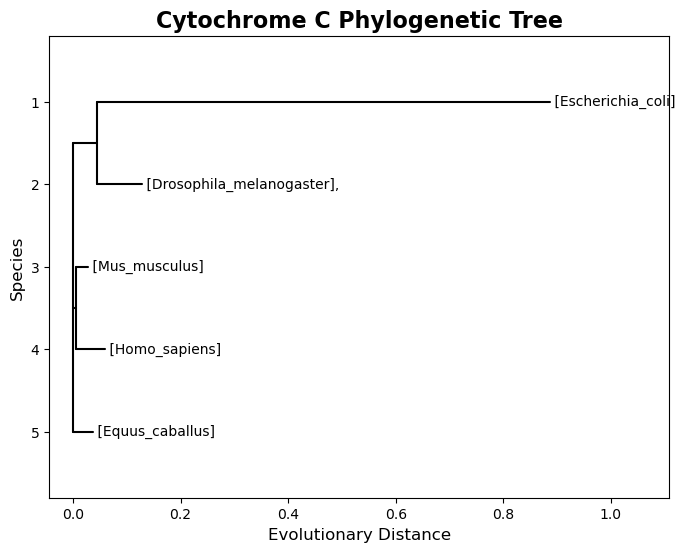

In [17]:
import matplotlib.pyplot as plt
from Bio import Phylo

# Customize the plot
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Draw the tree with better aesthetics
Phylo.draw(tree, do_show=False, axes=ax)

# Remove 'Inner' labels
for clade in tree.find_clades():
    if clade.name and "Inner" in clade.name:
        clade.name = ""

# Redraw without 'Inner' nodes
ax.clear()
Phylo.draw(tree, do_show=False, axes=ax)

# Customize
ax.set_title("Cytochrome C Phylogenetic Tree", fontsize=16, fontweight='bold')
ax.set_xlabel("Evolutionary Distance", fontsize=12)
ax.set_ylabel("Species", fontsize=12)

plt.show()

Distance Matrix

A distance matrix shows the pairwise evolutionary distances between sequences, calculated from your Multiple Sequence Alignment (MSA).

	•	Each number = evolutionary “distance” between two species.

	•	Smaller values = more similar sequences (closer relatives).
  
	•	Larger values = more divergent sequences (distant relatives).


| **Species**        | **Drosophila** | **Homo sapiens** | **E. coli** | **Mus musculus** | **Equus caballus** |  
|--------------------|----------------|------------------|-------------|------------------|--------------------|  
| **Drosophila**     | 0.000000       | 0.203571         | 0.924825    | 0.141071         | 0.165480           |  
| **Homo sapiens**   | 0.203571       | 0.000000         | 0.925134    | 0.076106         | 0.098765           |  
| **E. coli**        | 0.924825       | 0.925134         | 0.000000    | 0.935599         | 0.923351           |  
| **Mus musculus**   | 0.141071       | 0.076106         | 0.935599    | 0.000000         | 0.061728           |  
| **Equus caballus** | 0.165480       | 0.098765         | 0.923351    | 0.061728         | 0.000000           |  


Interpretation:

	•	Human ↔ Mouse: 0.076106 → Very close (as expected, both are mammals)

	•	Human ↔ Drosophila: 0.203571 → Moderate distance (both are eukaryotes, but distant relatives)

	•	E. coli ↔ All others: ~0.92-0.93 → Very far apart (prokaryote vs eukaryotes)

	•	Horse ↔ Mouse: 0.061728 → Very close (both are mammals)